<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul>

#  Прогнозирование заказов такси

Компания «желтое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Задача - построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from catboost import Pool, cv
from sklearn.linear_model import Ridge
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
random = 42

Загрузка данных

In [ ]:
data = pd.read_csv('/datasets/taxi.csv')

In [ ]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Пропусков и пустых значений нет

Изменение типа данных для столбца с датами

In [ ]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [ ]:
data = data.set_index('datetime')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


У нас имеются данные с марта по август 2018 года

In [ ]:
data = data.sort_index()
data.index.is_monotonic

True

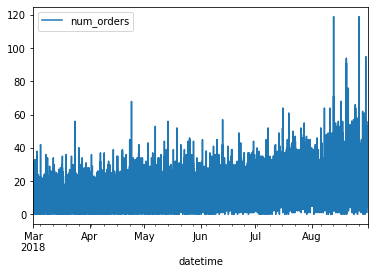

In [ ]:
data.plot();

Разделим по 1 часу, т.к. задача предсказания на час

In [ ]:
data = data.resample('1H').sum()

## Анализ

Ряд не является стационарным, т.к. меняется его среднее.

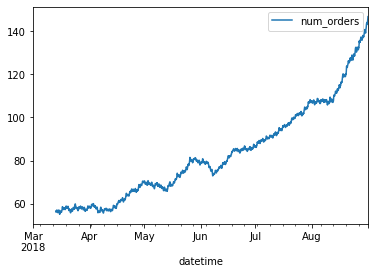

In [ ]:
data.rolling(300).mean().plot();

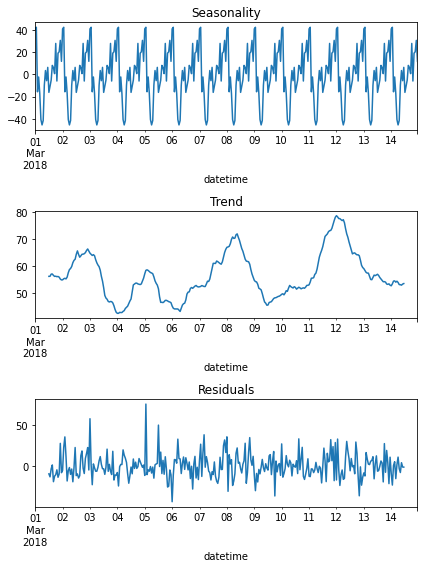

In [ ]:
decomposed = seasonal_decompose(data['num_orders']['2018-03-01':'2018-03-14'])

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.seasonal.plot(ax=plt.gca());
plt.title('Seasonality')
plt.subplot(312)

decomposed.trend.plot(ax=plt.gca());
plt.title('Trend')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca());
plt.title('Residuals')
plt.tight_layout()

Исходя из этих данных имеется определённый спад вызовов такси к выходным

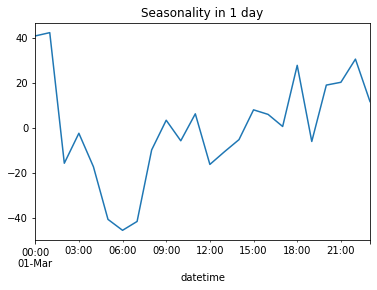

In [ ]:
decomposed.seasonal['2018-03-01':'2018-03-01'].plot(ax=plt.gca());
plt.title('Seasonality in 1 day');

На суточной сезонности имеется спад с ночи до 6 утра и до 21 часа в течении дня, с небольшими просадками.

Создание признаков и разделение на выборки

In [ ]:
data_new = data.copy()
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(data_new, 60, 3)

train, test = train_test_split(data_new, shuffle=False, test_size=0.1)
train = train.dropna()

Выделение признаков и target

In [ ]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

## Обучение

Линейная регрессия

In [ ]:
%%time
model = RandomForestRegressor(random_state=random)

param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [10, 30]
}

tscv = TimeSeriesSplit(n_splits = 5)

gs_model = GridSearchCV(
    model,
    param_grid=param_grid,
    cv = tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

gs_model.fit(features_train, target_train)

print(f'best_score: {gs_model.best_score_ * -1}')

print(f'best_params: {gs_model.best_params_}')

best_score: 24.51039549232996
best_params: {'max_depth': 30, 'n_estimators': 300}
CPU times: user 3min 55s, sys: 1.03 s, total: 3min 56s
Wall time: 3min 56s


Ridge

In [ ]:
%%time
model_ridge = Ridge(random_state=random)

param_grid_ridge = {
    'alpha': np.arange(0, 0.21, 0.01),
    "fit_intercept": [True, False]
}

tscv = TimeSeriesSplit(n_splits = 5)

gs_ridge = GridSearchCV(
    model_ridge,
    param_grid=param_grid_ridge,
    cv = tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

gs_ridge.fit(features_train, target_train)

print(f'best_score: {gs_ridge.best_score_ * -1}')

print(f'best_params: {gs_ridge.best_params_}')

best_score: 24.6471866590925
best_params: {'alpha': 0.2, 'fit_intercept': False}
CPU times: user 7.93 s, sys: 16.1 s, total: 24.1 s
Wall time: 24 s


In [ ]:
result = pd.DataFrame(
    [gs_ridge.best_score_ * -1, gs_model.best_score_ * -1],
    index=['Ridge', 'RandomForest'],
    columns=['RMSE']
)
result

,RMSE
Ridge,24.647187
RandomForest,24.510395


Лучший результат у модели ridge.

## Тестирование

In [ ]:
print("Ridge:",(mean_squared_error(target_test,gs_model.predict(features_test),squared=False)))

Ridge: 42.16824160073954


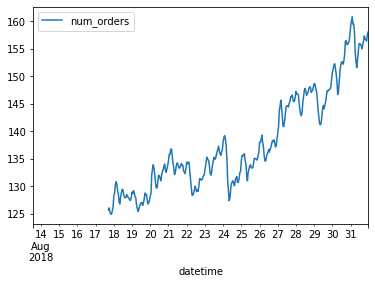

In [ ]:
pd.DataFrame(target_test).rolling(100).mean().plot();

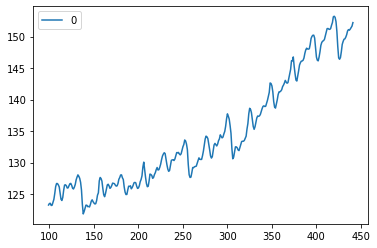

In [ ]:
pd.DataFrame(gs_model.predict(features_test)).rolling(100).mean().plot();

In [ ]:
pd.DataFrame(target_test).head(20)

,num_orders
datetime,
2018-08-13 14:00:00,102
2018-08-13 15:00:00,175
2018-08-13 16:00:00,144
2018-08-13 17:00:00,152
2018-08-13 18:00:00,104
2018-08-13 19:00:00,91
2018-08-13 20:00:00,82
2018-08-13 21:00:00,160
2018-08-13 22:00:00,104


In [ ]:
pd.DataFrame(gs_model.predict(features_test)).head(20)

,0
0,102.783333
1,139.826667
2,155.410000
3,130.573333
4,87.086667
5,102.473333
6,97.596667
7,110.940000
8,129.670000
9,161.040000


### Вывод

В ходе обработки данные были разделены по часам, ряд данных не является стационарным, т.к. меняется его среднее. Добавлены признаки и разделение данных на выборки. Обучено две модели RandomForest и ridge, лучший результат показала RandomForest, с средней ошибкой на обучающей выборке 24.5, для сравнения у Ridge почти столько же 24,6. На тестовой выборке модель RandomForest показа значение rmse 42.16, что менее порогового значения в 48. Рекомендуется использование этой модели, т.к. время обучения и значение ошибки у неё лучше линейной регрессии.